Je mets tous les fichiers que je veux traiter dans une liste

In [25]:
# Importer les bibliothèques
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
import os
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset


# Définir les répertoires
data_directory = 'data/mars/test/data/'  # Chemin vers le dossier contenant les fichiers CSV et MiniSEED
output_directory = 'output/'  # Répertoire pour sauvegarder les résultats

# Créer le répertoire de sortie s'il n'existe pas
os.makedirs(output_directory, exist_ok=True)

# Obtenir la liste des fichiers CSV
csv_files = [f for f in os.listdir(data_directory) if f.endswith('.csv')]
print(csv_files)

['XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv', 'XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.csv', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed_summary.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed_summary.csv', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.csv', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.csv', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.csv', 'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed_summary.csv', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed_summary.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.csv', 'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.csv', 'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed_summary.csv', 'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.csv']


La prochaine cellule on s'en fou pour l'instant

In [12]:
for csv_file in csv_files:
    cat_directory = './data/mars/test/data'
    cat_file = cat_directory + '/'+csv_file
    cat = pd.read_csv(cat_file)
    csv_file = f'{cat_file}'
    # Remplacer .csv par .mseed
    mseed_file = csv_file.replace('csv','mseed')
    st = read(mseed_file)
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    # Initialize figure
    fig,ax = plt.subplots(1,1,figsize=(10,3))
    # Plot trace
    ax.plot(tr_times,tr_data)
    # Mark detection
    ax.axvline(x = arrival, color='red',label='Rel. Arrival')
    ax.legend(loc='upper left')
    # Make the plot pretty
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    ax.set_title(f'{mseed_file}', fontweight='bold')
    # Définition des seuils de déclenchement
    thr_on = 4
    thr_off = 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Création du graphique
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# Tracé du sismogramme
    ax.plot(tr_times, tr_data, label='Sismogramme')

# Tracé des déclencheurs
    on_label_used = False
    off_label_used = False
    for i in range(len(on_off)):
        triggers = on_off[i]
    
    # Déclencheur "on" (début de l'événement)
        on_label = 'Début événement' if not on_label_used else ''
        ax.axvline(x=tr_times[triggers[0]], color='red', label=on_label)
        on_label_used = True
    
    # Déclencheur "off" (fin de l'événement)
        off_label = 'Fin événement' if not off_label_used else ''
        ax.axvline(x=tr_times[triggers[1]], color='purple', label=off_label)
        off_label_used = True

    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    plt.title('Sismogramme avec détections STA/LTA')
    plt.show()

    # Résumé des résultats
    summary_df = pd.DataFrame({
        'Event Start (s)': [event[0] for event in event_times],
        'Event End (s)': [event[1] for event in event_times],
        'Amplitude': amplitudes,
        'SNR': [snr] * len(event_times)
    })

    # Sauvegarder le résumé dans un fichier CSV
    summary_file = f'{mseed_file}_summary.csv'
    summary_df.to_csv(summary_file, index=False)

    print(f"Résumé sauvegardé dans : {summary_file}")
    

FileNotFoundError: [Errno 2] No such file or directory: './data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv'

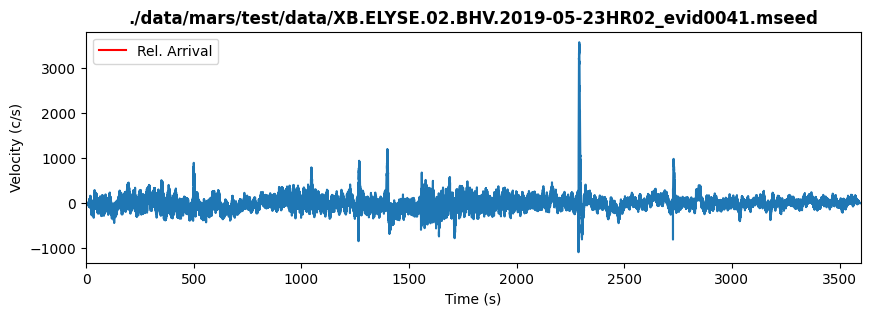

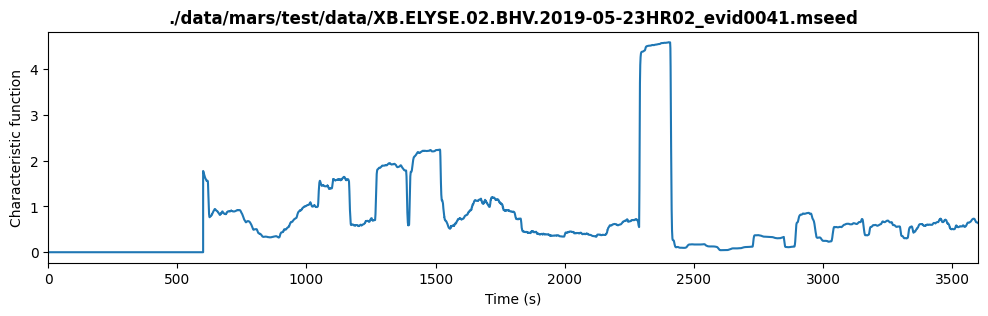

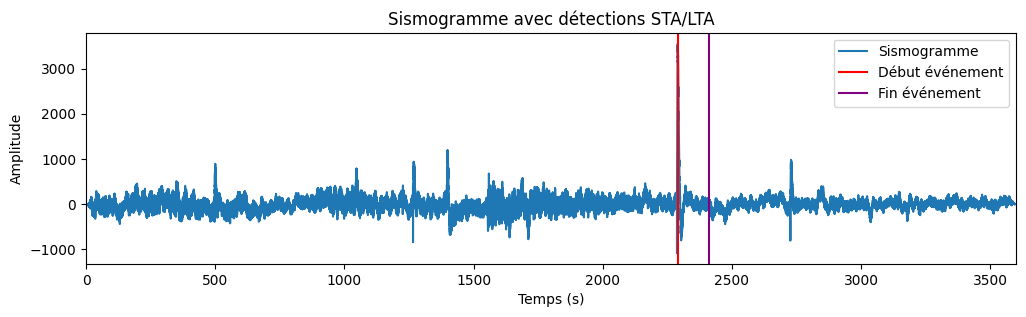

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv


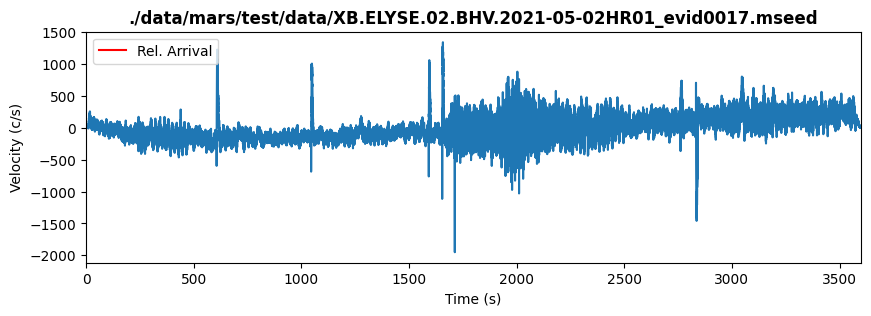

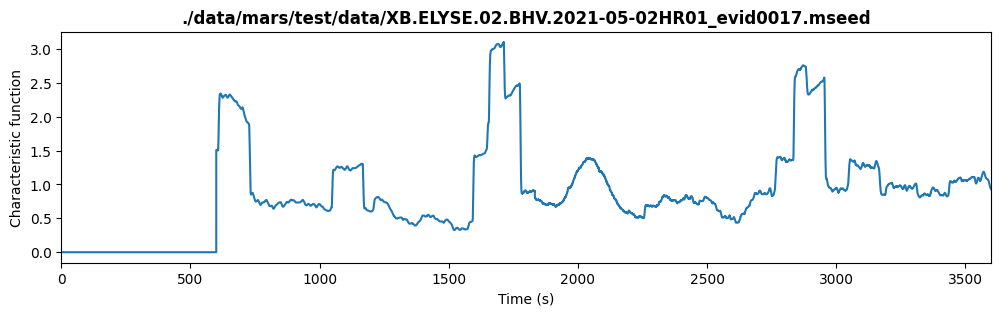

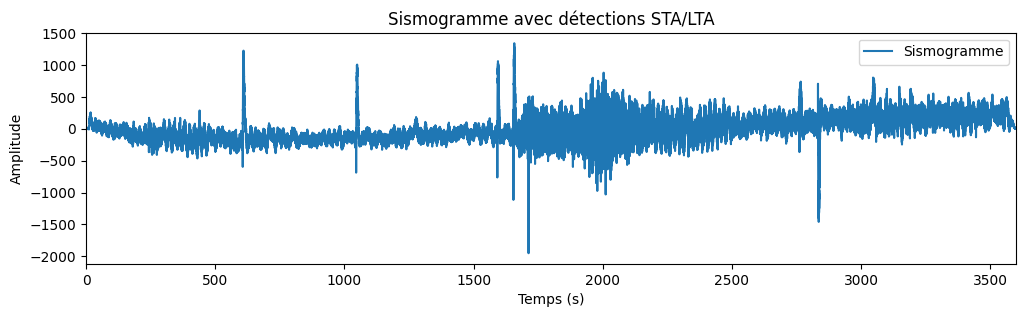

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed_summary.csv


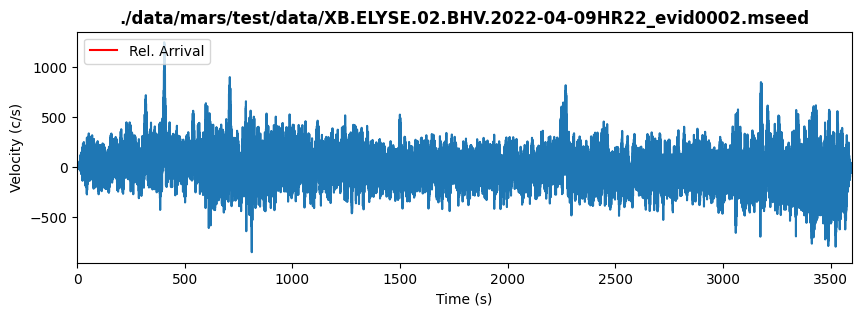

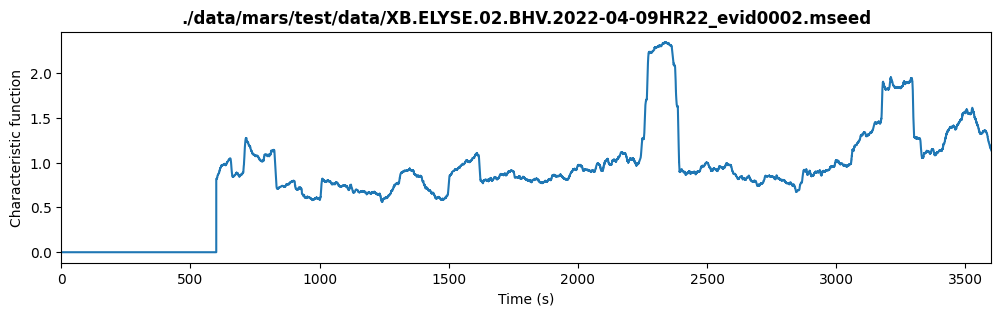

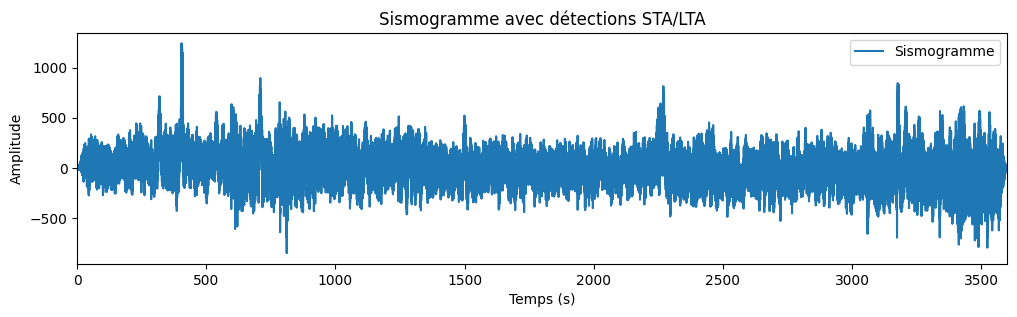

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed_summary.csv


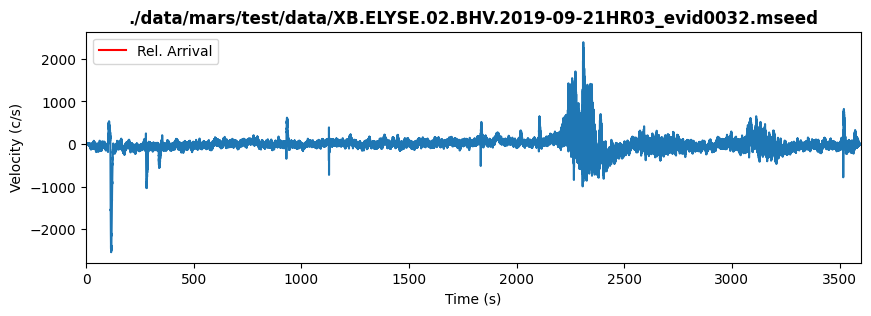

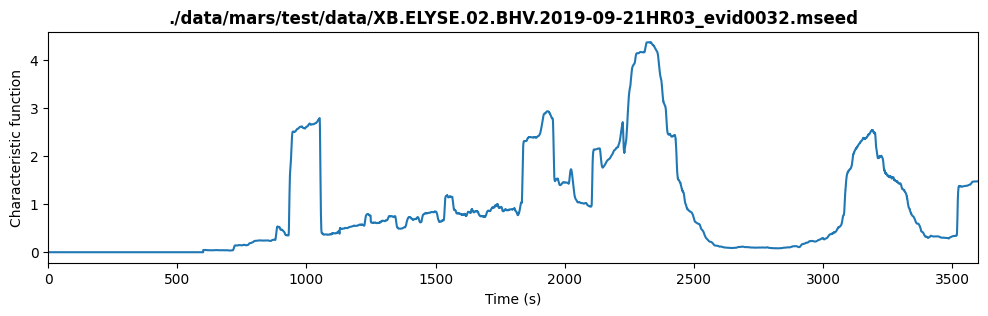

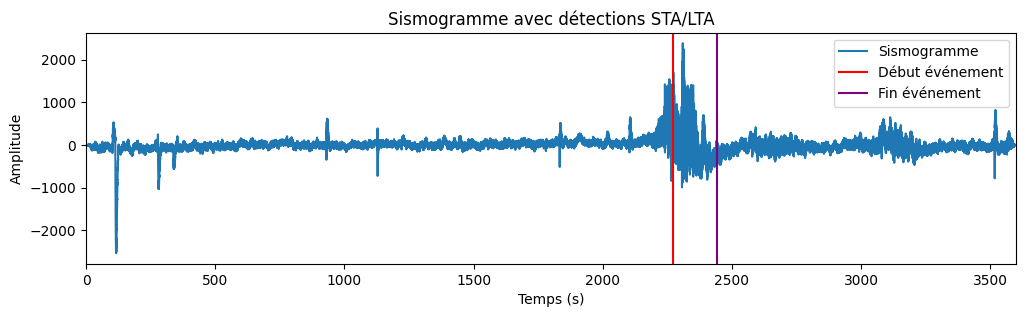

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv


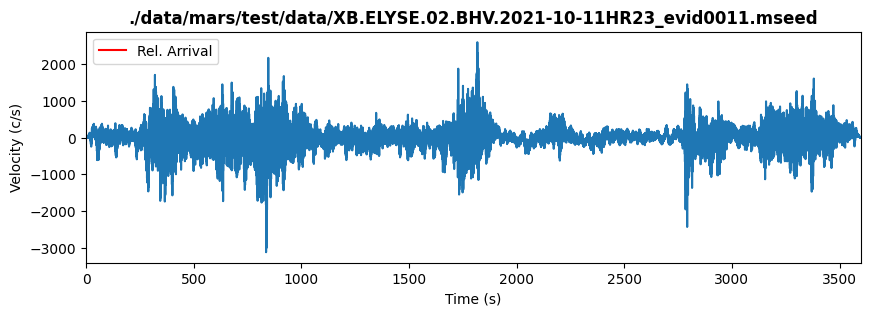

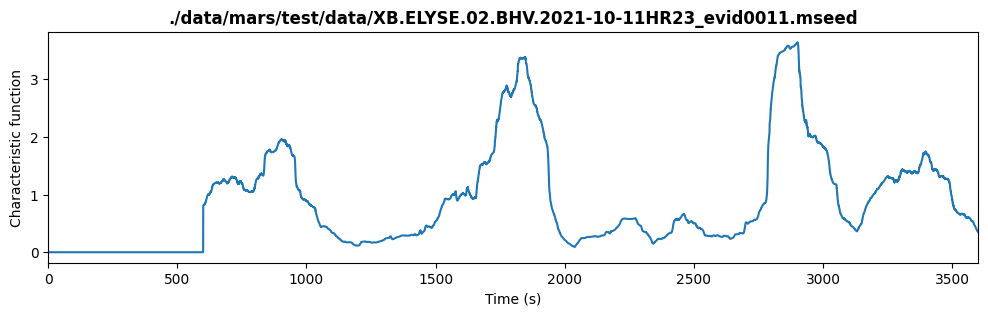

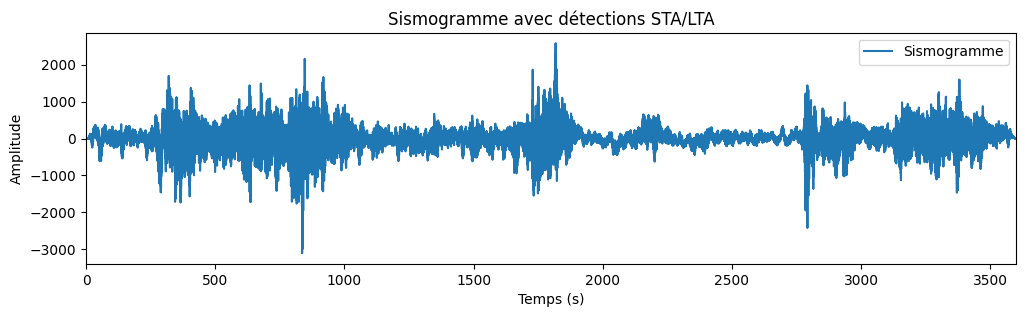

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv


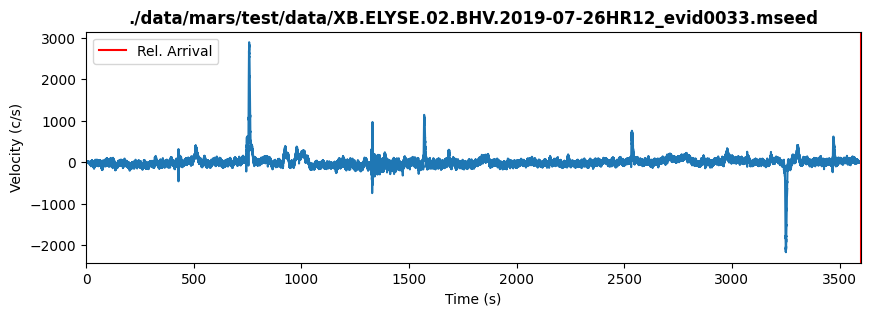

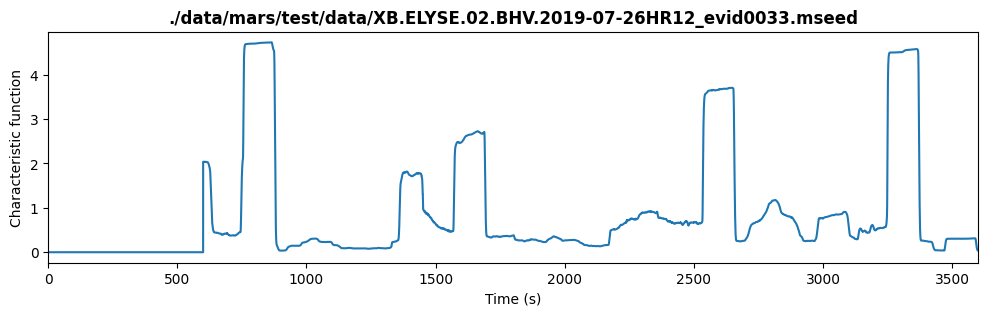

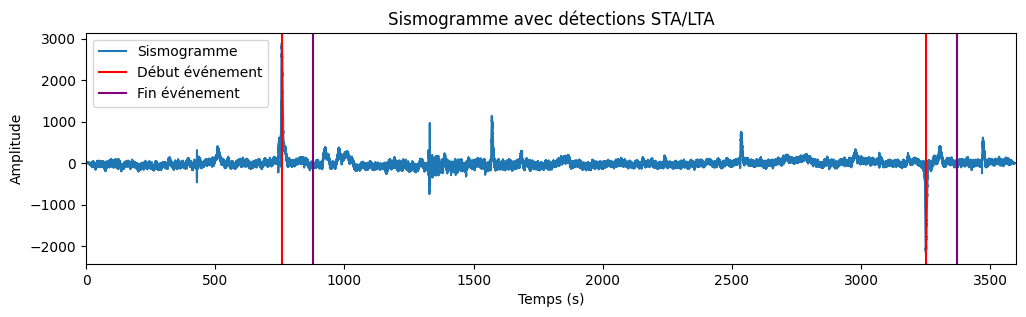

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed_summary.csv


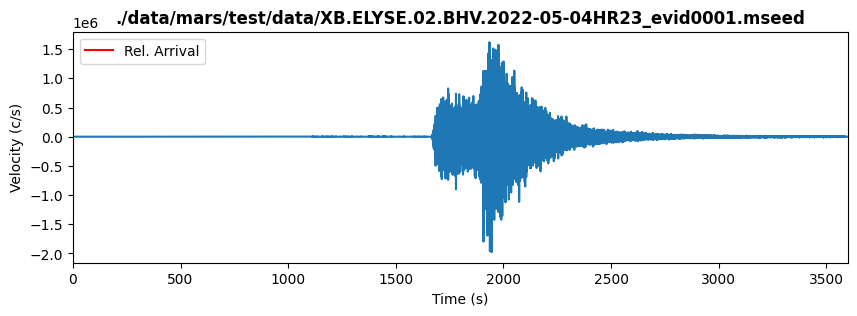

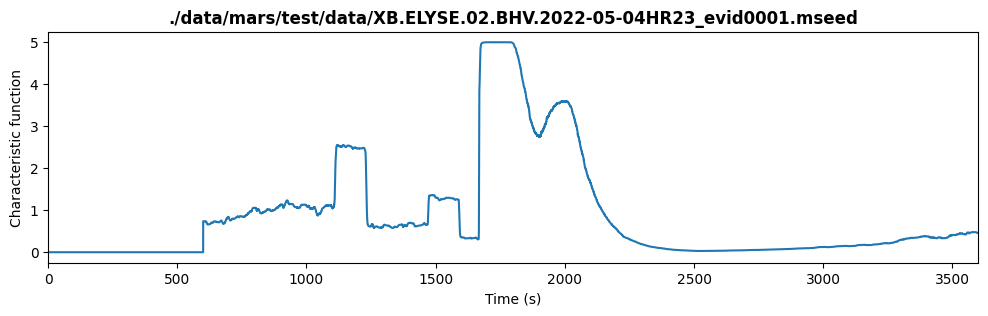

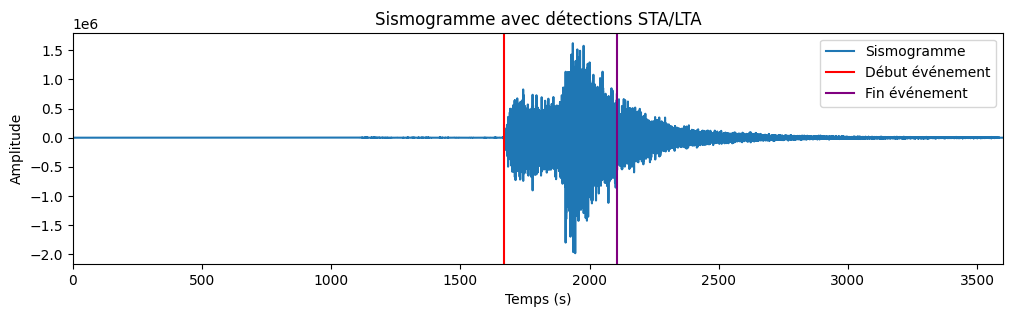

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed_summary.csv


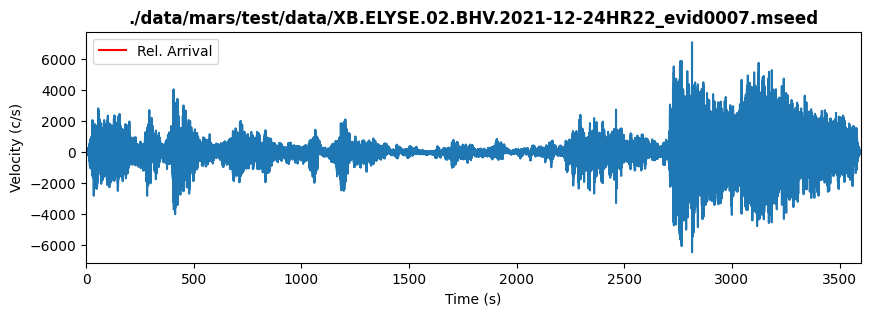

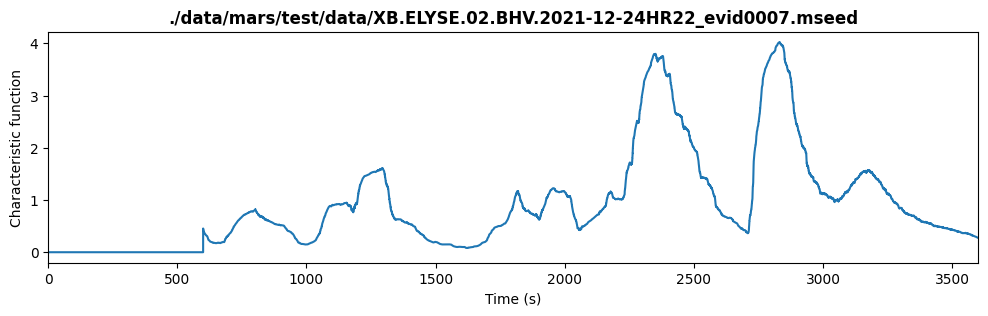

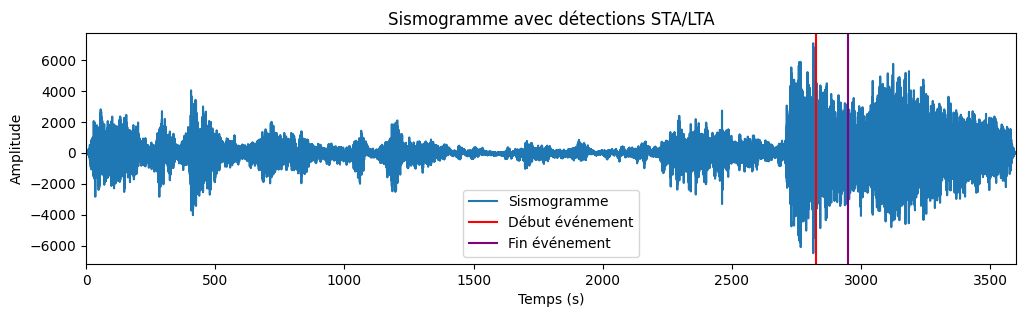

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed_summary.csv


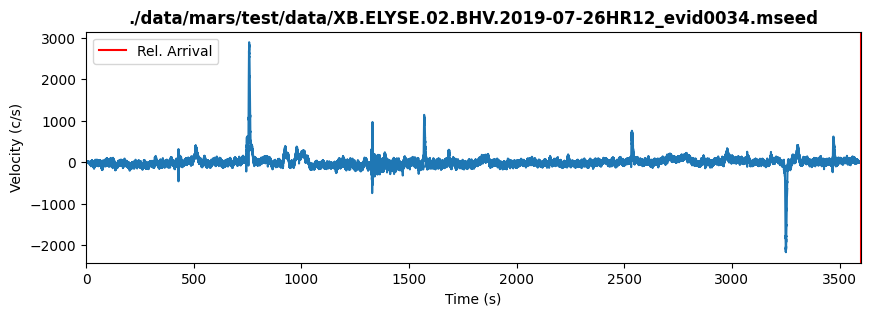

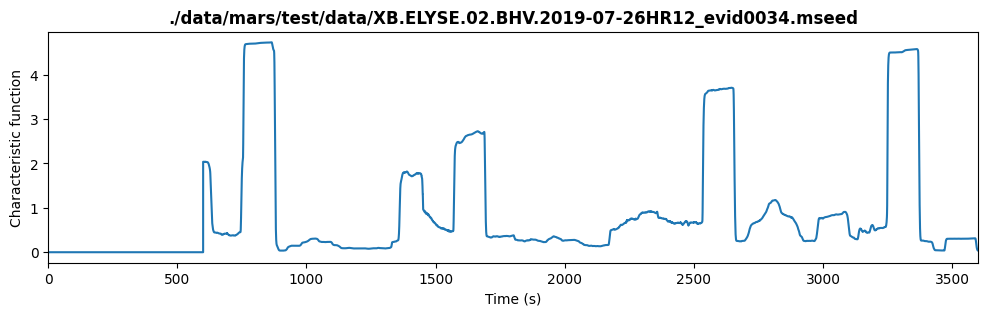

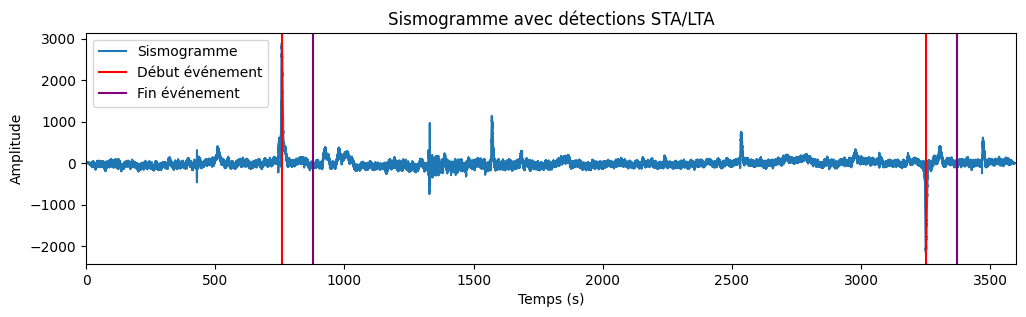

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed_summary.csv


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# ... (Votre code précédent ici) ...

# Après votre boucle for sur csv_files
for csv_file in csv_files:
    cat_directory = './data/mars/test/data'
    cat_file = cat_directory + '/' + csv_file
    cat = pd.read_csv(cat_file)
    csv_file = f'{cat_file}'
    mseed_file = csv_file.replace('csv', 'mseed')
    st = read(mseed_file)
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()

    # Initialize figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(tr_times, tr_data)
    ax.axvline(x=arrival, color='red', label='Rel. Arrival')
    ax.legend(loc='upper left')
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    # Définition des seuils de déclenchement
    thr_on = 4
    thr_off = 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Création du graphique
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, tr_data, label='Sismogramme')

    # Tracé des déclencheurs
    event_times = []
    amplitudes = []
    on_label_used = False
    off_label_used = False
    for i in range(len(on_off)):
        triggers = on_off[i]
        
        # Déclencheur "on" (début de l'événement)
        event_start = tr_times[triggers[0]]
        event_end = tr_times[triggers[1]]
        
        ax.axvline(x=event_start, color='red', label='Début événement' if not on_label_used else '')
        ax.axvline(x=event_end, color='purple', label='Fin événement' if not off_label_used else '')
        
        event_times.append((event_start, event_end))
        amplitudes.append(np.max(tr_data[triggers[0]:triggers[1]]))  # Amplitude max de l'événement
        
        on_label_used = True
        off_label_used = True

    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    plt.title('Sismogramme avec détections STA/LTA')
    plt.show()

    # Calcul du rapport signal sur bruit (SNR)
    signal_power = np.mean(tr_data ** 2)
    noise_power = np.mean((tr_data[triggers[1]:] - np.mean(tr_data[triggers[1]:])) ** 2)  # SNR après le premier événement
    snr = signal_power / noise_power

    # Résumé des résultats
    summary_df = pd.DataFrame({
        'Event Start (s)': [event[0] for event in event_times],
        'Event End (s)': [event[1] for event in event_times],
        'Amplitude': amplitudes,
        'SNR': [snr] * len(event_times)
    })

    # Sauvegarder le résumé dans un fichier CSV
    summary_file = f'{mseed_file}_summary.csv'
    summary_df.to_csv(summary_file, index=False)

    print(f"Résumé sauvegardé dans : {summary_file}")

In [43]:
import pandas as pd
import glob

# Spécifiez le répertoire où se trouvent vos fichiers CSV
directory_path = './data/mars/test/data/*summary.csv'

# Lire tous les fichiers CSV qui correspondent au motif
for csv_file in glob.glob(directory_path):
    # Lire le fichier CSV dans un DataFrame
    df = pd.read_csv(csv_file)
    
    # Afficher le nom du fichier et les 5 premières lignes du DataFrame
    print(f'Données de {csv_file}:')
    print(df.head(), '\n')  # Afficher les 5 premières lignes et ajouter un saut de ligne pour la clarté

Données de ./data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv:
   Event Start (s)  Event End (s)   Amplitude       SNR
0           2291.6        2412.45  3338.50708  2.989197 

Données de ./data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv:
Empty DataFrame
Columns: [Event Start (s), Event End (s), Amplitude, SNR]
Index: [] 

Données de ./data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed_summary.csv:
   Event Start (s)  Event End (s)    Amplitude       SNR
0           757.05         879.40  2894.658691  3.609432
1          3251.10        3372.65   411.316864  3.609432 

Données de ./data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv:
   Event Start (s)  Event End (s)    Amplitude       SNR
0          2272.45        2440.75  2389.922363  2.567152 

Données de ./data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed_summary.csv:
   Event Start (s)  Event End (s)    Amplitude     

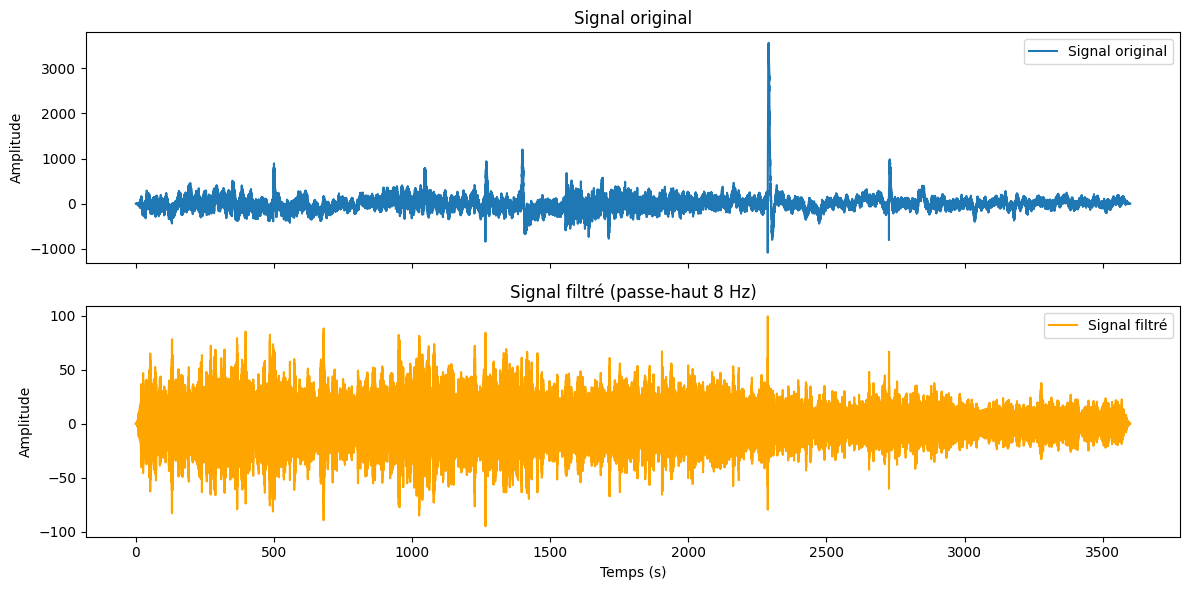

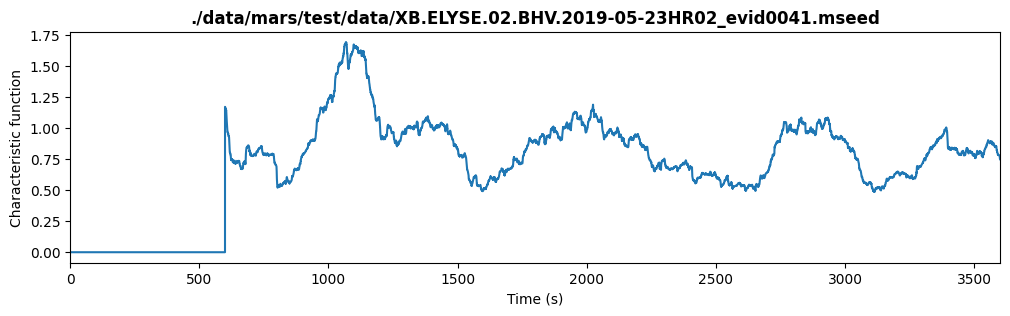

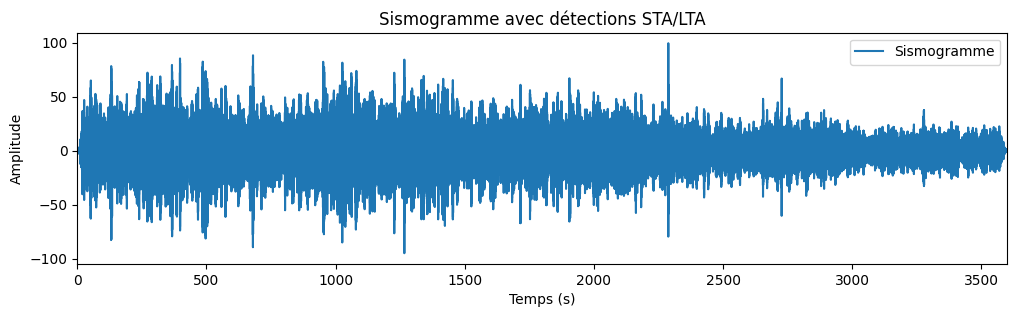

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv


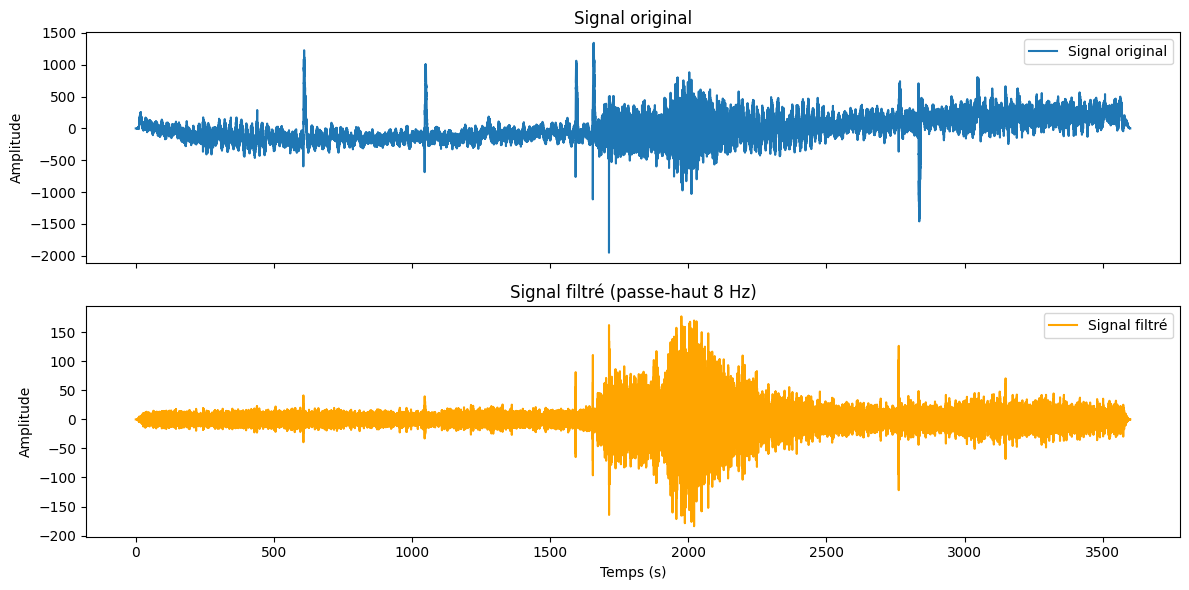

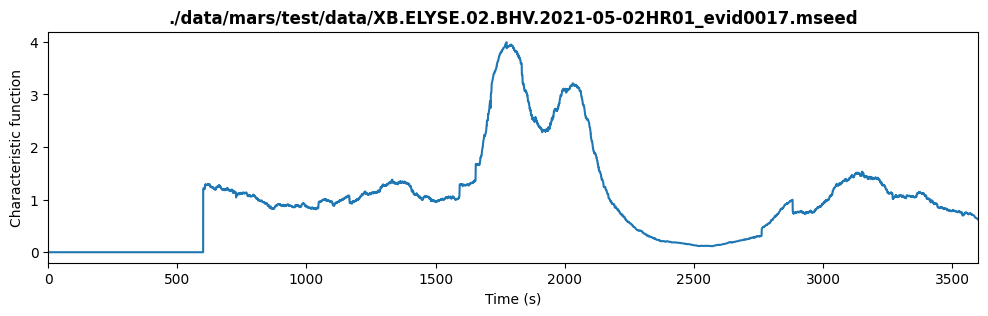

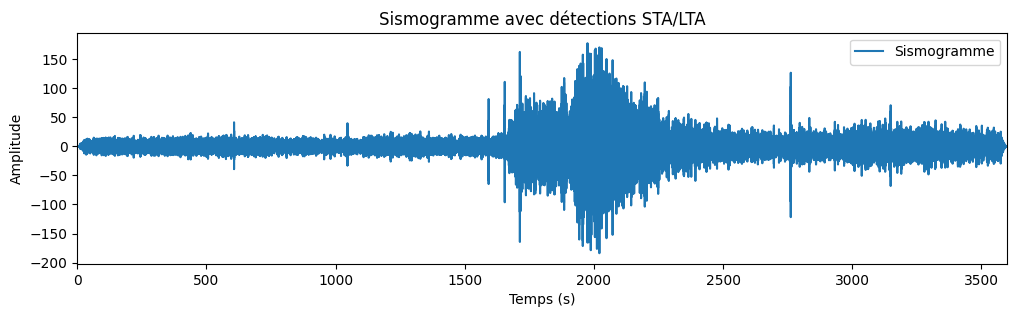

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed_summary.csv


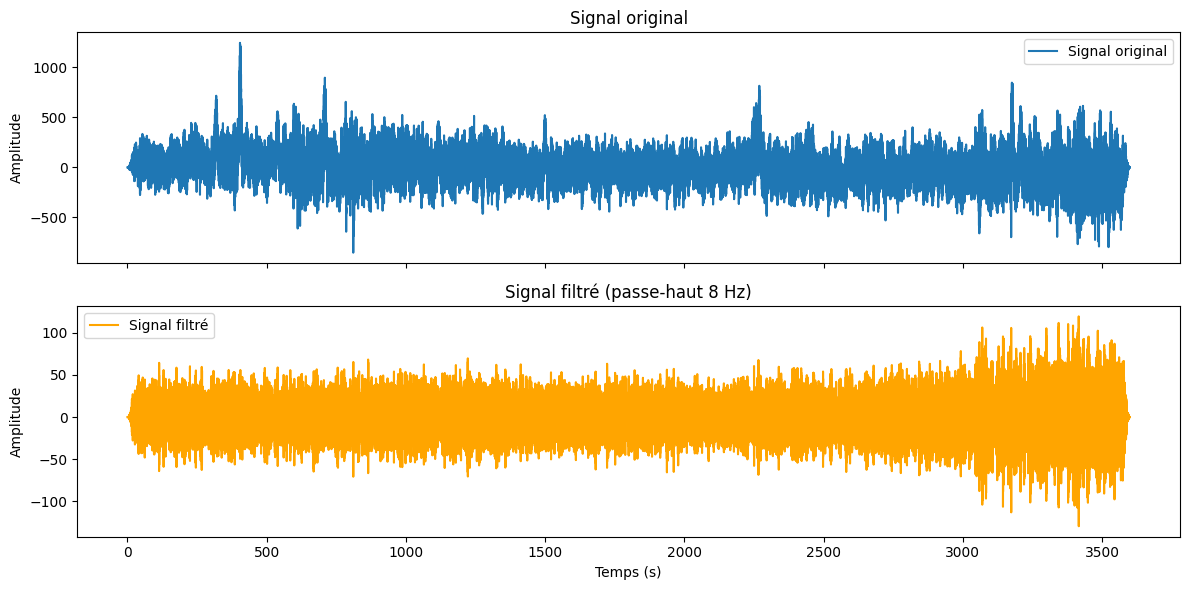

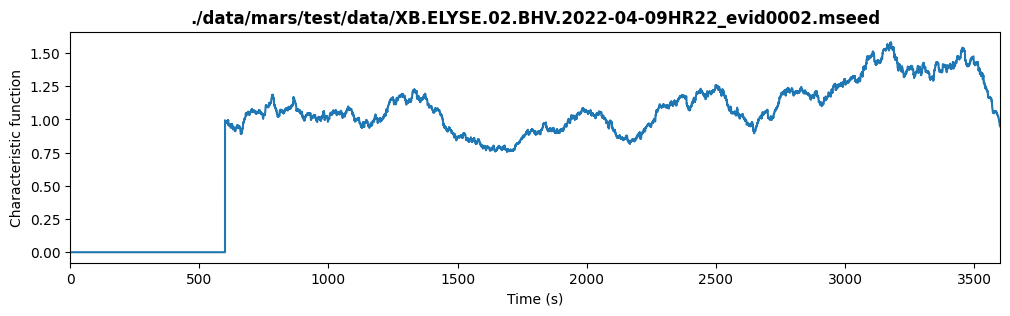

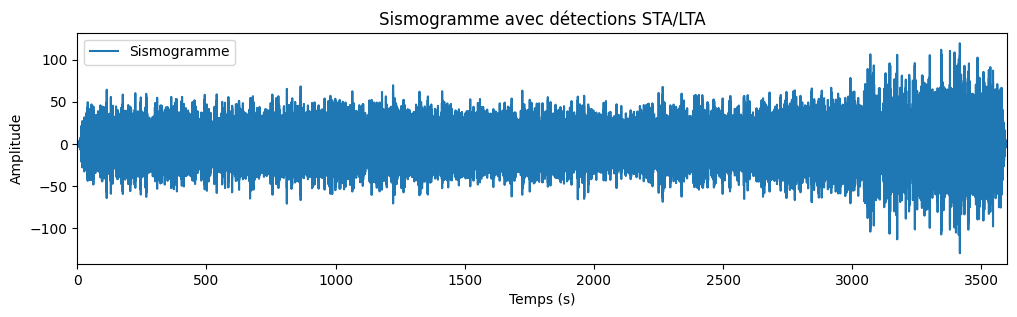

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed_summary.csv


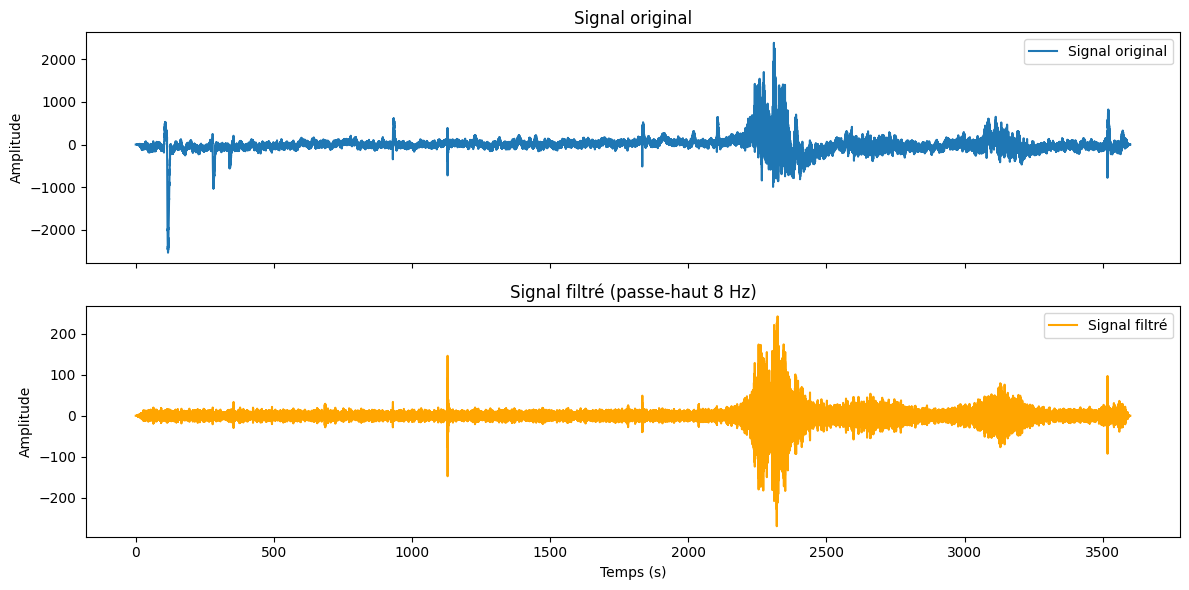

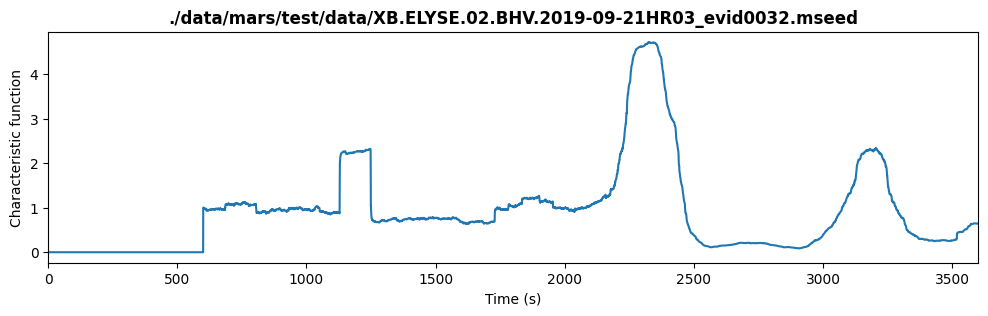

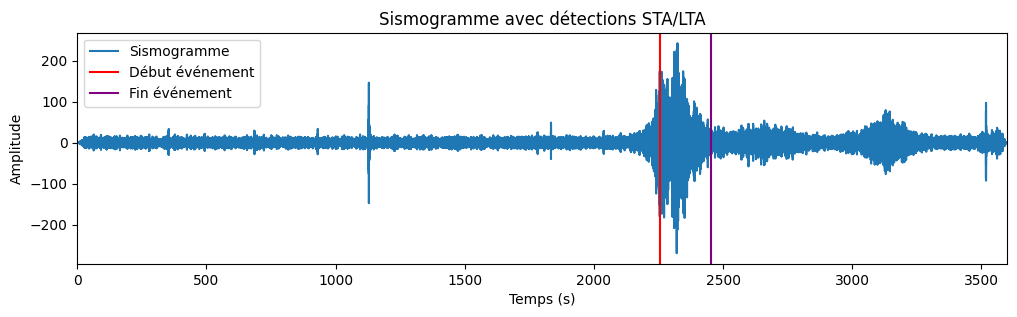

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv


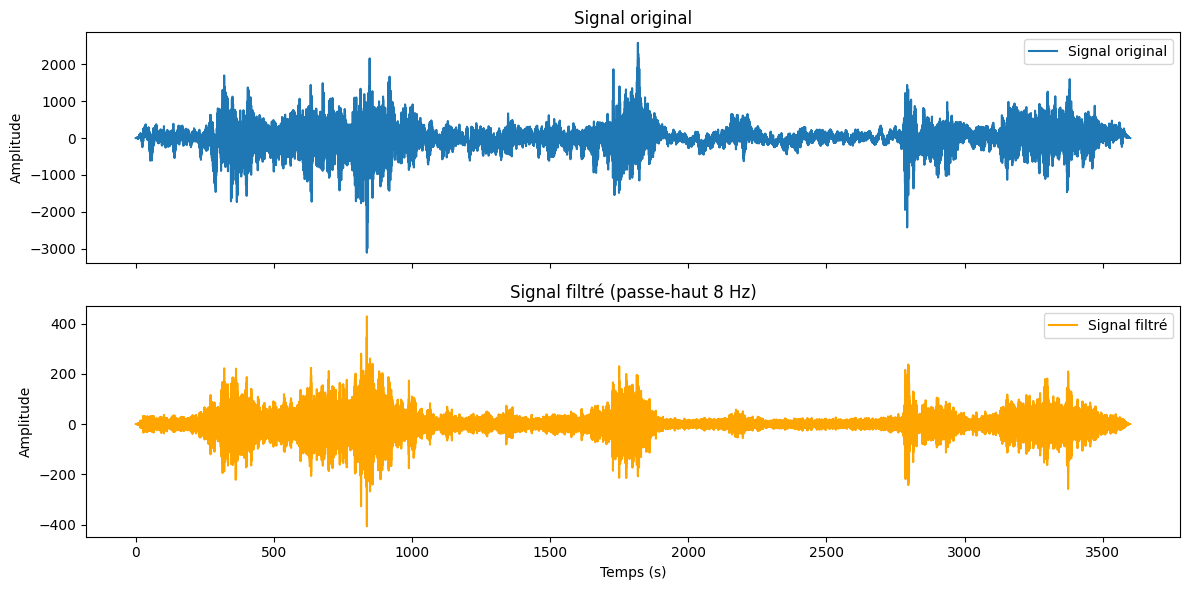

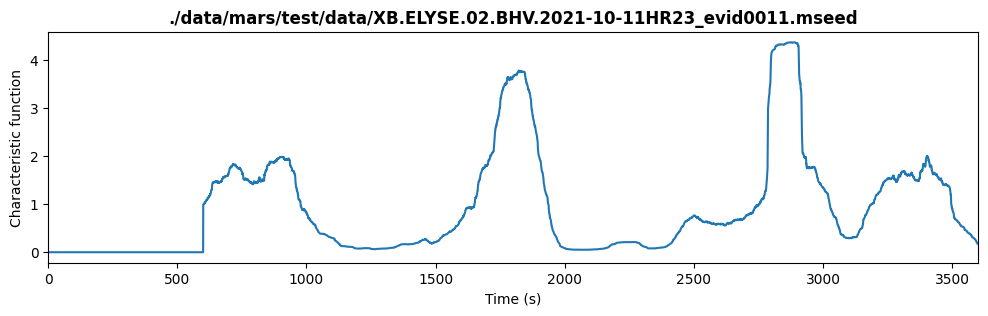

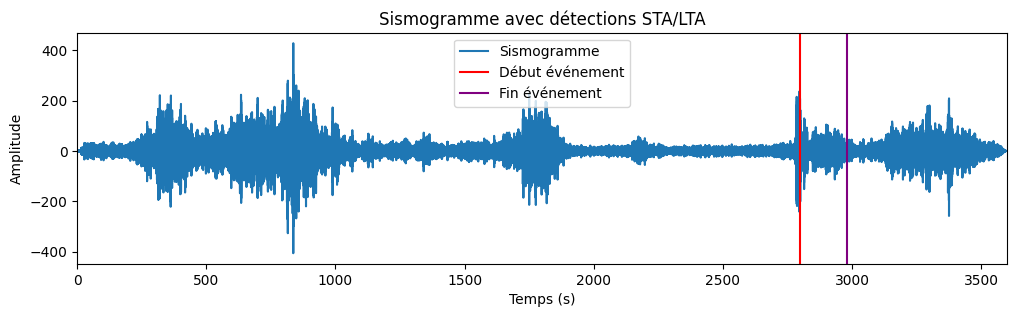

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv


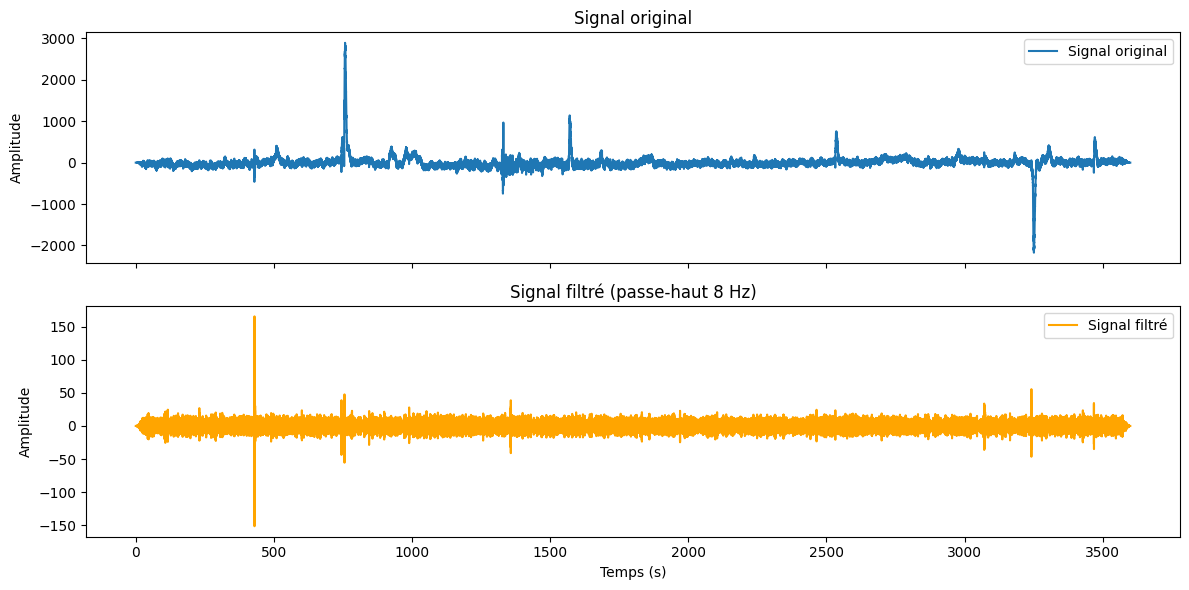

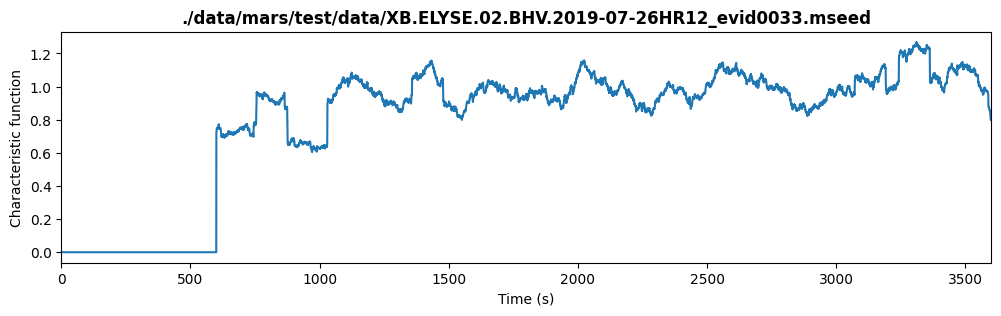

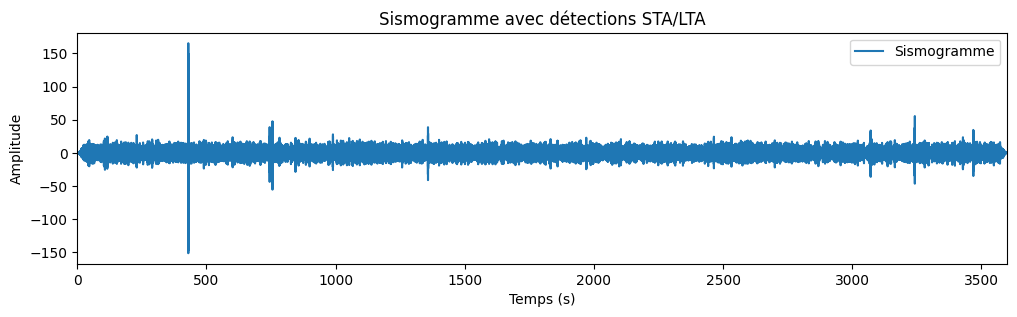

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed_summary.csv


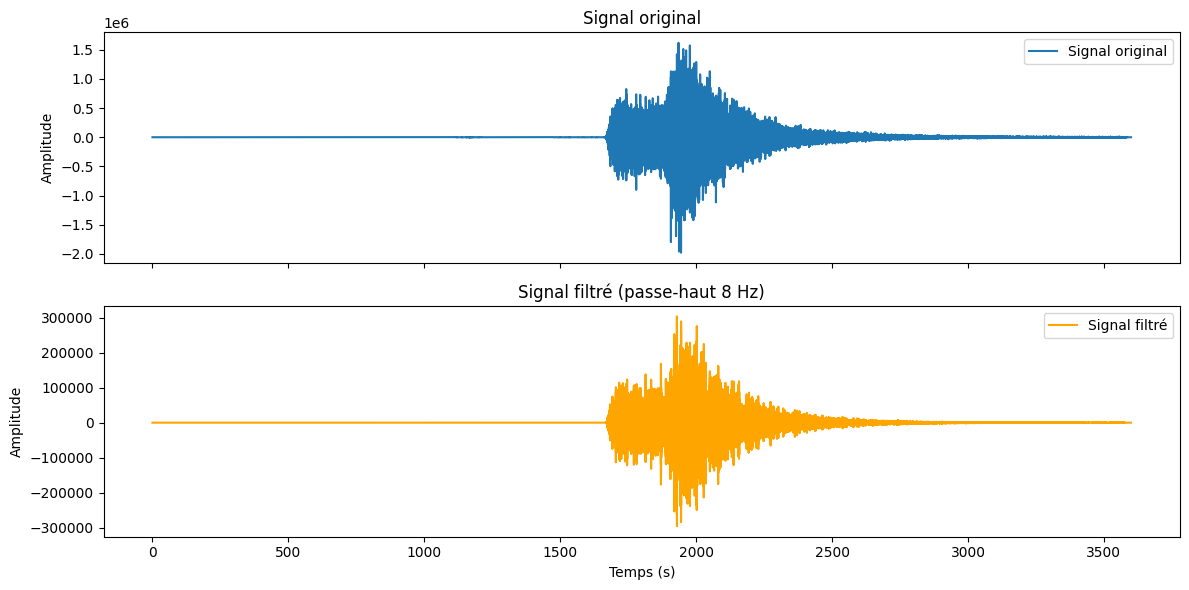

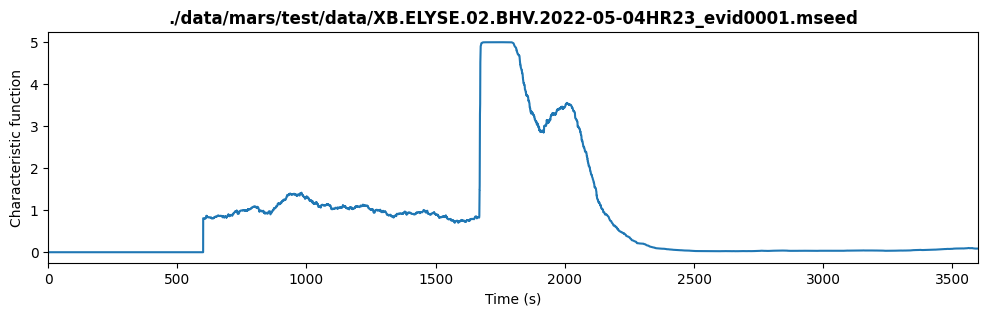

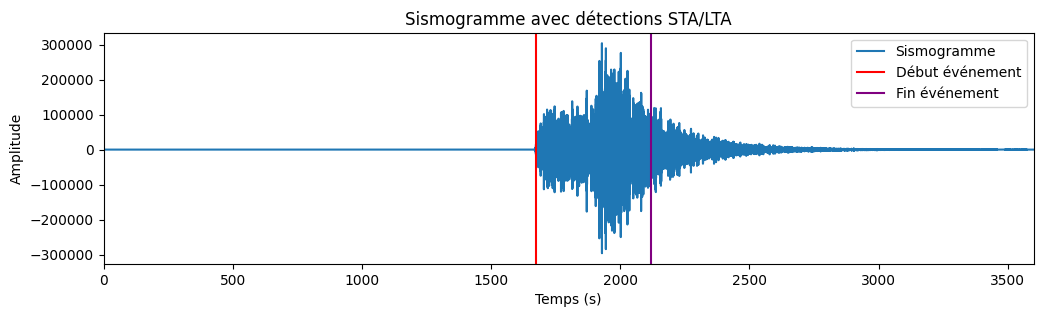

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed_summary.csv


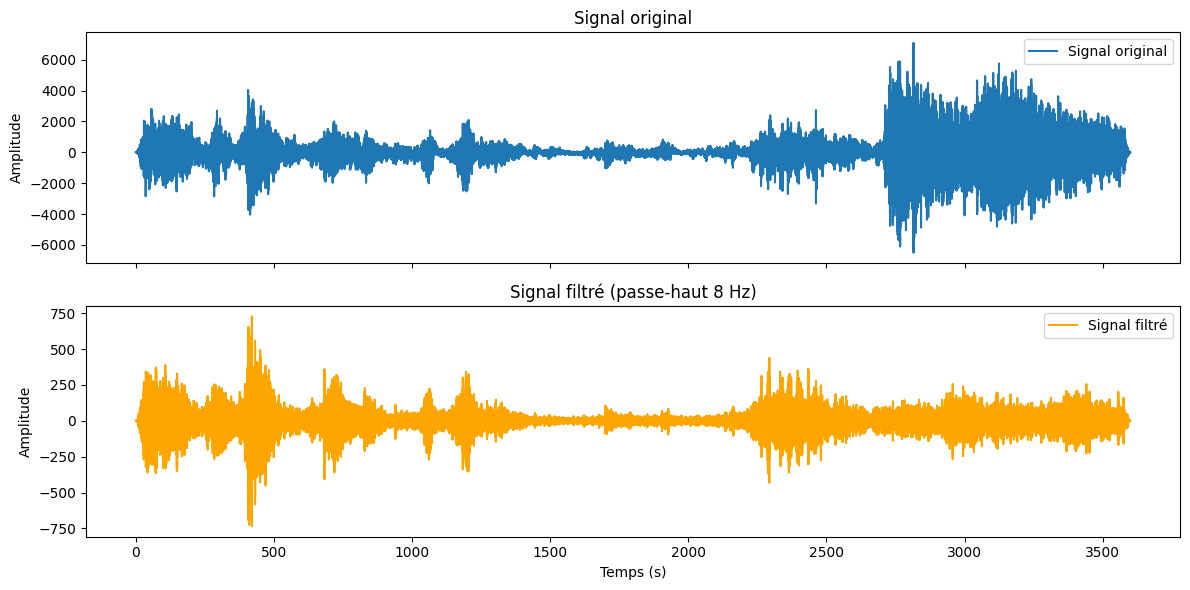

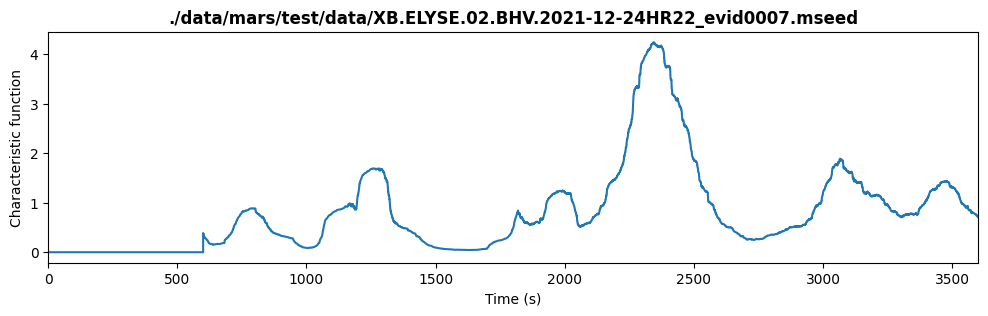

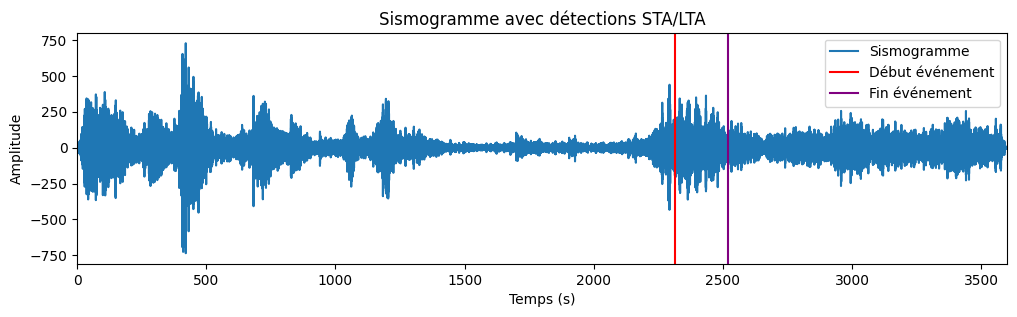

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed_summary.csv


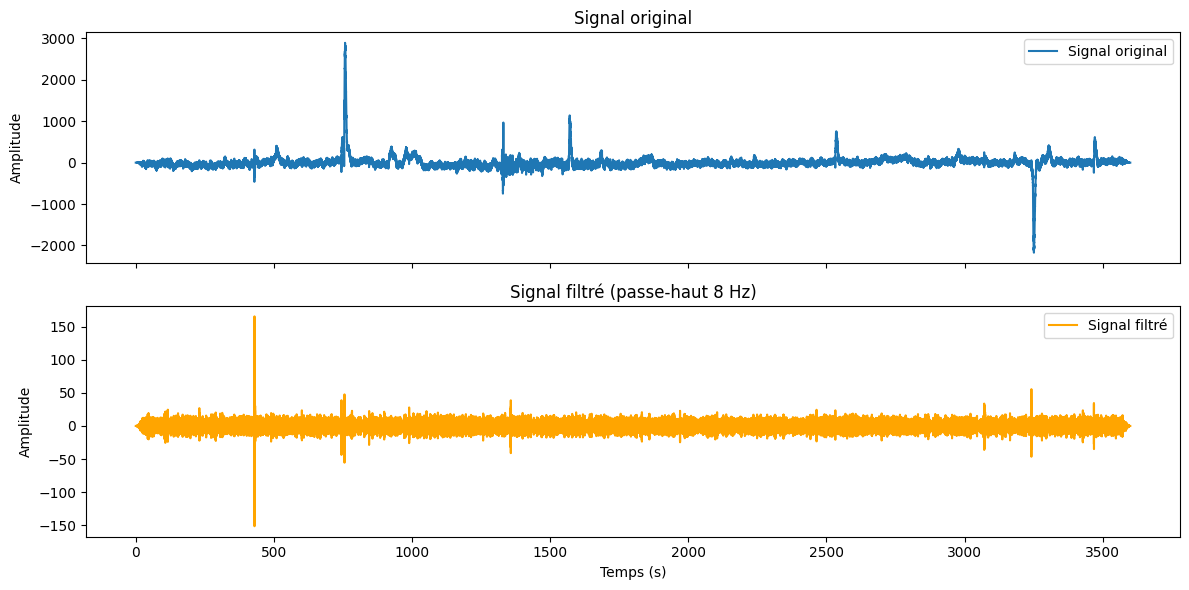

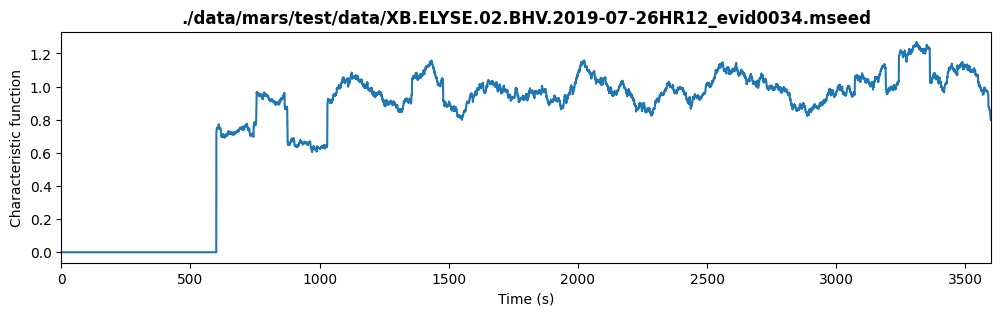

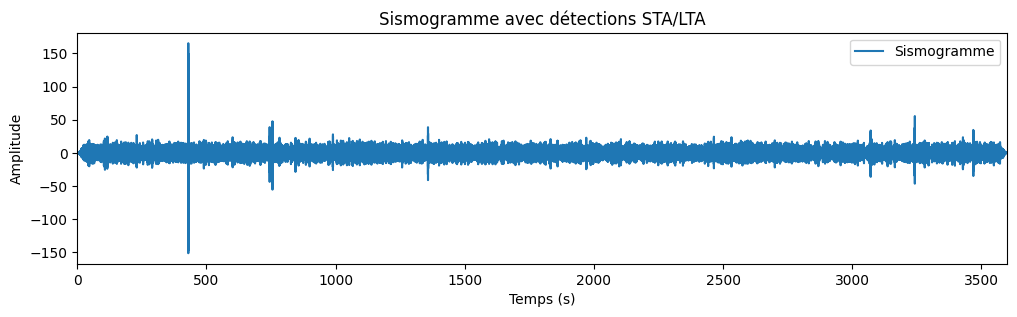

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed_summary.csv


In [24]:
# Application d'un filtre passe-haut sur tous les signaux avant d'appliquer la méthode STA/LTA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.signal.filter import highpass

for csv_file in csv_files:
    cat_directory = './data/mars/test/data'
    cat_file = cat_directory + '/' + csv_file
    cat = pd.read_csv(cat_file)
    csv_file = f'{cat_file}'
    mseed_file = csv_file.replace('csv', 'mseed')
    st = read(mseed_file)
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()

    corner_freq = 8
    tr_filtered = tr.copy()
    tr_filtered.data = highpass(tr.data, corner_freq, df=tr.stats.sampling_rate)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax1.plot(tr_times, tr.data, label='Signal original')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.set_title('Signal original')
    ax2.plot(tr_times, tr_filtered.data, label='Signal filtré', color='orange')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Amplitude')
    ax2.legend()
    ax2.set_title(f'Signal filtré (passe-haut {corner_freq} Hz)')
    plt.tight_layout()
    plt.show()

    df = tr.stats.sampling_rate
    sta_len = 120
    lta_len = 600

    cft = classic_sta_lta(tr_filtered.data, int(sta_len * df), int(lta_len * df))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    ax.set_title(f'{mseed_file}', fontweight='bold')

    thr_on = 4
    thr_off = 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, tr_filtered.data, label='Sismogramme')

    event_times = []
    amplitudes = []
    on_label_used = False
    off_label_used = False
    for i in range(len(on_off)):
        triggers = on_off[i]
        event_start = tr_times[triggers[0]]
        event_end = tr_times[triggers[1]]
        ax.axvline(x=event_start, color='red', label='Début événement' if not on_label_used else '')
        ax.axvline(x=event_end, color='purple', label='Fin événement' if not off_label_used else '')
        event_times.append((event_start, event_end))
        amplitudes.append(np.max(tr_filtered.data[triggers[0]:triggers[1]]))
        on_label_used = True
        off_label_used = True

    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    plt.title('Sismogramme avec détections STA/LTA')
    plt.show()

    signal_power = np.mean(tr_filtered.data ** 2)
    noise_power = np.mean((tr_filtered.data[triggers[1]:] - np.mean(tr_filtered.data[triggers[1]:])) ** 2)
    snr = signal_power / noise_power

    summary_df = pd.DataFrame({
        'Event Start (s)': [event[0] for event in event_times],
        'Event End (s)': [event[1] for event in event_times],
        'Amplitude': amplitudes,
        'SNR': [snr] * len(event_times)
    })

    summary_file = f'{mseed_file}_summary.csv'
    summary_df.to_csv(summary_file, index=False)

    print(f"Résumé sauvegardé dans : {summary_file}")

In [ ]:
# Application d'un filtre passe-haut sur tous les signaux avant d'appliquer la méthode STA/LTA
# If your team is taking the manual approach, think about how you could display the seismic waves in different ways. Get creative!